***Visualizing and Analyzing the Data***

**Importing the necessary libraries**

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Saving the model
import pickle


**Read the dataset**

In [2]:
data = pd.read_csv("garments_worker_productivity.csv")
print(data.head())

       date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0        

**Correlation Analysis**

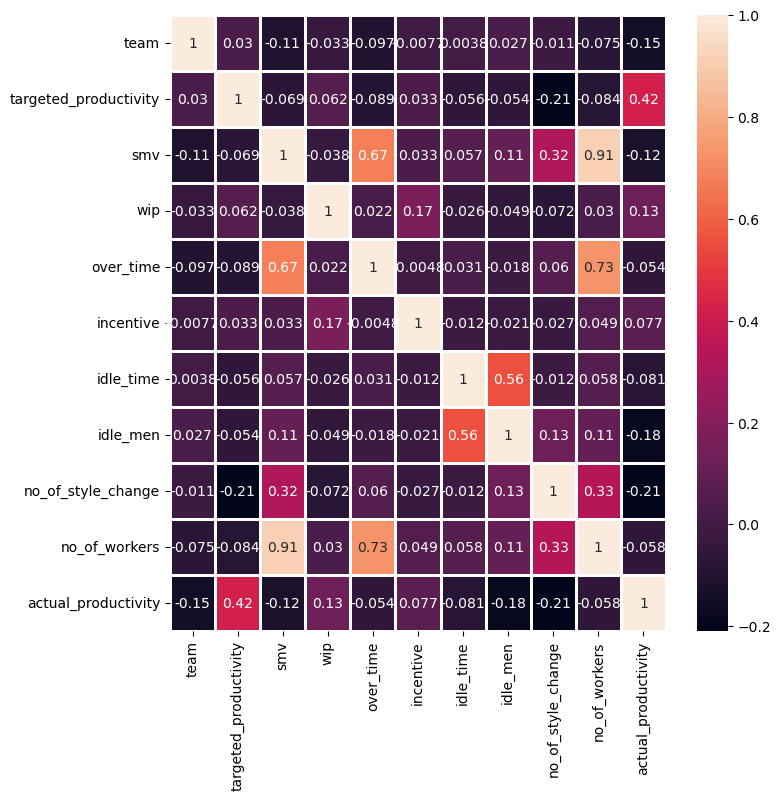

In [3]:
corrMatrix = data.select_dtypes(include=['number']).corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrMatrix, annot=True, linewidths=1, ax=ax)
plt.show()

**Descriptive Analysis**

In [4]:
data.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


***Data Preprocessing***

**Checking for Null Values**

In [5]:
data.shape

(1197, 15)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [7]:
print(data.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [8]:
# Drop 'wip' column if exists
if 'wip' in data.columns:
    data.drop(['wip'], axis=1, inplace=True)

**Handling Date and Department Column**

In [9]:
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data.drop(['date'], axis=1, inplace=True)


In [10]:
if 'department' in data.columns:
    data['department'] = data['department'].apply(lambda x: 'finishing' if 'finishing' in x.lower() else 'sewing')

In [11]:
categorical_cols = ['department', 'quarter', 'day'] if 'quarter' in data.columns else ['department', 'day']

**Separate features and target**

In [12]:
X_df = data.drop(['actual_productivity'], axis=1)  # Features
y = data['actual_productivity'].to_numpy()         # Target

**Handling Categorical Values**

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                le = LabelEncoder()
                output[col] = le.fit_transform(output[col])
        else:
            for colname, col in output.items():
                if output[colname].dtype == object:
                    le = LabelEncoder()
                    output[colname] = le.fit_transform(col)
        return output

mcle = MultiColumnLabelEncoder(columns=categorical_cols)
X_encoded = mcle.fit_transform(X_df)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

**Spilting Data into Train and Test**

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

***Model Building***

**1.Linear Regression Model**

In [16]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
pred_lr = model_lr.predict(x_test)

print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, pred_lr))
print("MSE:", mean_squared_error(y_test, pred_lr))
print("R2:", r2_score(y_test, pred_lr))

Linear Regression Performance:
MAE: 0.10636001215550112
MSE: 0.020952954761876034
R2: 0.2913123154775418


**2.Random Forest Model**

In [17]:
model_rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)

print("\nRandom Forest Performance:")
print("MAE:", mean_absolute_error(y_test, pred_rf))
print("MSE:", mean_squared_error(y_test, pred_rf))
print("R2:", r2_score(y_test, pred_rf))


Random Forest Performance:
MAE: 0.08580681722601405
MSE: 0.015568129692169114
R2: 0.47344219899891493


**3.Xgboost Model**

In [18]:
model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=0
)
model_xgb.fit(x_train, y_train)
pred_xgb = model_xgb.predict(x_test)

print("XGBoost Performance:")
print("MAE:", mean_absolute_error(y_test, pred_xgb))
print("MSE:", mean_squared_error(y_test, pred_xgb))
print("R2:", r2_score(y_test, pred_xgb))

XGBoost Performance:
MAE: 0.07904341491293163
MSE: 0.015048792808164598
R2: 0.4910076286958249


**Compare the Model and Evaluating the Performance of the Model**

In [19]:
# Create a dictionary to store results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [
        mean_absolute_error(y_test, pred_lr),
        mean_absolute_error(y_test, pred_rf),
        mean_absolute_error(y_test, pred_xgb)
    ],
    'MSE': [
        mean_squared_error(y_test, pred_lr),
        mean_squared_error(y_test, pred_rf),
        mean_squared_error(y_test, pred_xgb)
    ],
    'R2 Score': [
        r2_score(y_test, pred_lr),
        r2_score(y_test, pred_rf),
        r2_score(y_test, pred_xgb)
    ]
}

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df.sort_values(by='R2 Score', ascending=False))


Model Performance Comparison:
               Model       MAE       MSE  R2 Score
2            XGBoost  0.079043  0.015049  0.491008
1      Random Forest  0.085807  0.015568  0.473442
0  Linear Regression  0.106360  0.020953  0.291312


**Saving the best model**

In [20]:
with open("gwp.pkl", "wb") as f:
    pickle.dump(model_xgb, f)